In [2]:
%pip install pandas numpy matplotlib scikit-learn scipy pymoo seaborn forestci

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
%pip install duecredit

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
from sklearn.pipeline import Pipeline
import pandas as pd
from itertools import product
from datetime import datetime
import numpy as np
from sklearn.preprocessing    import StandardScaler, KBinsDiscretizer
from sklearn.model_selection  import train_test_split, KFold
from sklearn.metrics          import mean_squared_error, r2_score, mean_absolute_error
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.ensemble         import RandomForestRegressor
import xgboost                 as xgb
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.spatial.distance import cdist
import forestci as fci

from sklearn.gaussian_process.kernels import Matern, ConstantKernel, WhiteKernel, DotProduct, RBF, RationalQuadratic

from sklearn.metrics import mean_squared_error, r2_score
from scipy.optimize import minimize
from pymoo.problems.many import DTLZ2
from sklearn.model_selection import StratifiedShuffleSplit
import seaborn as sns
from scipy.stats import entropy
from itertools import product
n_obj = 3
k = 20
n_vars = n_obj + k - 1
problem = DTLZ2(n_var=n_vars, n_obj=n_obj)

def load_and_prepare(path="dtlz2_dataset1.csv"):
    df = pd.read_csv(path).dropna(subset=["frob_norm"])
    X = df[["lambda_1","lambda_2","lambda_3"]].values
    y = df["frob_norm"].values.reshape(-1,1)
    return df, X, y

def build_models( optimized_rf, optimized_xg):
    return {
        "RF":  optimized_rf,
        "XGB": optimized_xg
    }


def scalarized_objective(x, lam, problem):
    f = problem.evaluate(np.array([x]))[0]
    return np.dot(lam, f)

def evaluate_models(models, X_train, y_train, X_test, y_test, y_scaler):
    results = []
    # Invertiamo y_scaler solo sul test finale
    for name, model in models.items():
        # 4.1) Fit su train
        model.fit(X_train, y_train.ravel())
        # 4.2) Predict + std se disponibile
        y_pred = model.predict(X_test)
        # su GP estrai std:
        if hasattr(model, "predict") and "GaussianProcessRegressor" in type(model).__name__:
            y_std = model.predict(X_test, return_std=True)[1] * y_scaler.scale_[0]
        else:
            y_std = None

        # 4.3) inverse transform dei valori
        y_test_inv = y_scaler.inverse_transform(y_test.reshape(-1, 1))
        y_pred_inv = y_scaler.inverse_transform(y_pred.reshape(-1,1))

        # 4.4) metrica
        rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
        r2   = r2_score(y_test_inv, y_pred_inv)
        mae  = mean_absolute_error(y_test_inv, y_pred_inv)

        results.append({
            "model": name,
            "RMSE": rmse,
            "R2"  : r2,
            "MAE" : mae
        })
        plt.figure(figsize=(6, 6))
        if y_std is not None:
            plt.errorbar(y_test_inv, y_pred_inv.ravel(), yerr=y_std, fmt='o', alpha=0.6, label="Predicted ± Std")
        else:
            plt.scatter(y_test_inv, y_pred_inv, alpha=0.6, label="Predicted")
        mn, mx = y_test_inv.min(), y_test_inv.max()
        plt.plot([mn, mx], [mn, mx], 'r--', label="Ideal")
        plt.title(f"{name}: True vs Predicted")
        plt.xlabel("True Values")
        plt.ylabel("Predicted Values")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()



    return pd.DataFrame(results).set_index("model")

def active_learning_with_ei(model, X_scaler, y_scaler, lambda_grid, dataset, top_k=10):
    """
    Usa Expected Improvement (EI) per selezionare nuovi punti λ e aggiorna il dataset.
    """
    # Calcola il miglior valore corrente di y (minimizzazione)
    y_best_scaled = np.min(dataset["frob_norm"].values)

    # Seleziona i nuovi punti λ con EI
    lambda_selected = diversity_enhanced_ei(
        lambda_candidates=lambda_grid,
        model=model,
        X_scaler=X_scaler,
        y_best_scaled=y_best_scaled,
        top_k=top_k,
        w_ei=1.0,
        w_div=0.1,
        w_sigma=0.5
    )

    # Aggiorna il dataset con i nuovi punti λ
    updated_dataset = update_dataset_with_new_data(lambda_selected, dataset)
    return updated_dataset

def diversity_enhanced_eiRF(lambda_candidates, model, X_scaler, y_best_scaled,
                            top_k=50, w_ei=1.0, w_div=0.1, w_sigma=1.0):
    # Estrai il modello Random Forest dalla pipeline, se necessario
    if isinstance(model, Pipeline):
        model = model.named_steps['rf']  # Sostituisci 'rf' con il nome corretto del passaggio nella pipeline

    Xc = X_scaler.transform(lambda_candidates)
    # Predizioni per ogni albero
    trees = np.vstack([t.predict(Xc) for t in model.estimators_])
    mu = trees.mean(axis=0)
    sigma = trees.std(axis=0) + 1e-12

    imp = mu - y_best_scaled
    Z = imp / sigma
    ei = imp * norm.cdf(Z) + sigma * norm.pdf(Z)

    div = cdist(lambda_candidates, lambda_candidates).mean(axis=1)
    score = w_ei * ei + w_div * div + w_sigma * sigma
    idx = np.argsort(-score)[:top_k]
    return lambda_candidates[idx]

def stratified_split(X, y, n_bins=10, test_size=0.2, random_state=42):
    """
    Stratifica lo split train/test basandosi su binning di λ₁.
    """
    # Applica binning su λ₁
    discretizer = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='uniform')
    stratify_labels = discretizer.fit_transform(X[:, 0].reshape(-1, 1)).ravel()  # Binning su λ₁

    # Split stratificato
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=stratify_labels
    )
    return X_train, X_test, y_train, y_test

def select_best_kernel(X_train, y_train, verbose=True):
    kernels = [

    ConstantKernel(1.0) * Matern(length_scale=1.0, nu=1.5),
    ConstantKernel(1.0) * DotProduct() + WhiteKernel(),
    ConstantKernel(1.0) * (RBF(length_scale=1.0) + WhiteKernel()),
    ConstantKernel(1.0) * RBF(length_scale=1.0) + Matern(length_scale=1.0, nu=1.5),
    ConstantKernel(1.0) * (RationalQuadratic() + Matern(nu=1.5)) + WhiteKernel()
]

    best_score = -np.inf
    best_kernel = None
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    if verbose:
        print("[Kernel Selection] Inizio selezione del kernel...")

    for kernel_idx, kernel in enumerate(kernels):
        scores = []
        mae_scores = []  # Per memorizzare il MAE sui dati di validazione
        if verbose:
            print(f"\n[Kernel {kernel_idx + 1}/{len(kernels)}] Testando kernel: {kernel}")

        for fold_idx, (train_idx, val_idx) in enumerate(kf.split(X_train)):
            X_tr, X_val = X_train[train_idx], X_train[val_idx]
            y_tr, y_val = y_train[train_idx], y_train[val_idx]

            # Addestramento del modello
            model = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=20, normalize_y=True)
            model.fit(X_tr, y_tr)

            # Calcolo del log-marginal-likelihood
            log_likelihood = model.log_marginal_likelihood_value_
            scores.append(log_likelihood)

            # Predizione sui dati di validazione
            y_pred = model.predict(X_val)
            mae = mean_absolute_error(y_val, y_pred)
            mae_scores.append(mae)

            if verbose:
                print(f"  [Fold {fold_idx + 1}] Log-Likelihood: {log_likelihood:.4f}, MAE: {mae:.4f}")

        avg_score = np.mean(scores)
        avg_mae = np.mean(mae_scores)  # Media del MAE

        if verbose:
            print(f"[Kernel {kernel_idx + 1}] Log-Likelihood medio: {avg_score:.4f}, MAE medio: {avg_mae:.4f}")

        if avg_score > best_score:
            best_score = avg_score
            best_kernel = kernel
            if verbose:
                print(f"  [Kernel {kernel_idx + 1}] Miglior kernel trovato finora!")

    if verbose:
        print(f"\n[Kernel Selection] Kernel migliore: {best_kernel} con Log-Likelihood medio: {best_score:.4f}")

    return best_kernel


def tune_rf_bayes(X_train, y_train, n_iter=50, cv=5):
    from sklearn.pipeline import Pipeline
    from sklearn.feature_selection import VarianceThreshold
    from sklearn.pipeline import Pipeline
    from sklearn.decomposition import PCA
    from skopt import BayesSearchCV
    from sklearn.ensemble import RandomForestRegressor

    # Calcola il massimo valore di n_components
    max_components = min(X_train.shape[0], X_train.shape[1])

    # Pipeline: var threshold + PCA + RF(oob_score)
    pipe = Pipeline([
        ('var', VarianceThreshold(1e-2)),
        ('pca', PCA(n_components=min(20, max_components))),  # Limita n_components
        ('rf', RandomForestRegressor(oob_score=True, random_state=42))
    ])

    # Spazi di ricerca
    search_spaces = {
        'rf__n_estimators': (100, 1000),
        'rf__max_depth': (5, 50),
        'rf__min_samples_leaf': (1, 10),
        'rf__max_features': ['sqrt', 'log2', 0.5]
    }

    opt = BayesSearchCV(
        pipe, search_spaces,
        n_iter=n_iter,
        scoring='r2',
        cv=cv,
        n_jobs=-1,
        random_state=42,
        verbose=0
    )
    opt.fit(X_train, y_train.ravel())
    print("Bayes RF best R²:", opt.best_score_)
    return opt.best_estimator_

def calculate_confidence_intervals(rf_model, X_train, X_test):
    # Estrai il modello Random Forest dalla pipeline
    if isinstance(rf_model, Pipeline):
        rf_model = rf_model.named_steps['rf']  # Sostituisci 'rf' con il nome corretto del passaggio nella pipeline

    # Calcola la varianza utilizzando forestci
    variance = fci.random_forest_error(rf_model, X_train.shape, X_test)
    return variance

def diversity_enhanced_ei(lambda_candidates, model, X_scaler, y_best_scaled, top_k=100, w_ei=1.0, w_div=0.06, w_sigma=0.3):
    X_cand_scaled = X_scaler.transform(lambda_candidates)

    # Controlla se il modello supporta return_std
    if hasattr(model, "predict") and "GaussianProcessRegressor" in type(model).__name__:
        mu, sigma = model.predict(X_cand_scaled, return_std=True)
    else:
        mu = model.predict(X_cand_scaled)
        sigma = np.zeros_like(mu)  # Imposta sigma a zero se non supportato

    with np.errstate(divide='warn'):
        imp = mu.reshape(-1, 1) - y_best_scaled
        Z = imp / sigma.reshape(-1, 1)
        ei = imp * norm.cdf(Z) + sigma.reshape(-1, 1) * norm.pdf(Z)
        ei = ei.ravel()

    dist_matrix = cdist(lambda_candidates, lambda_candidates)
    diversity_score = dist_matrix.mean(axis=1)
    combined_score = w_ei * ei + w_div * diversity_score + w_sigma * sigma
    top_idx = np.argsort(-combined_score)[:top_k]
    return lambda_candidates[top_idx]


def update_dataset_with_new_data(lambda_selected, dataset, base_filename="updated_dataset", window_size=10):
    # Calcola n_vars e n_obj dal dataset

    n_vars = problem.n_var
    n_obj = problem.n_obj

    new_x_star, new_frob_norms, new_variances, new_P_vectors = [], [], [], []
    for lam in lambda_selected:
        # Assicurati che n_vars sia definito correttamente
        res = minimize(scalarized_objective, x0=np.full(n_vars, 0.5), args=(lam, problem), method='L-BFGS-B', bounds=[(0.0, 1.0)] * n_vars)
        x_opt = res.x
        new_x_star.append(x_opt)
        if len(new_x_star) >= 2:
            X_local = StandardScaler().fit_transform(np.array(new_x_star[-window_size:]))
            C = np.cov(X_local.T) + np.eye(n_vars) * 1e-8
            new_frob_norms.append(np.linalg.norm(C, ord='fro'))
            new_variances.append(np.var(X_local, axis=0))
            P = np.linalg.cholesky(C)
            new_P_vectors.append(P[np.tril_indices_from(P)])
        else:
            new_frob_norms.append(np.nan)
            new_variances.append(np.full(n_vars, np.nan))
            new_P_vectors.append(np.full((n_vars * (n_vars + 1)) // 2, np.nan))

    new_data_dict = {f"lambda_{i+1}": lambda_selected[:, i] for i in range(n_obj)}
    new_data_dict["frob_norm"] = new_frob_norms
    for i in range(n_vars):
        new_data_dict[f"x_star_{i+1}"] = [x[i] for x in new_x_star]
        new_data_dict[f"var_x_star_{i+1}"] = [v[i] for v in new_variances]
    for i in range(len(new_P_vectors[0])):
        new_data_dict[f"P_vec_{i+1}"] = [p[i] for p in new_P_vectors]
    new_data_dict["source"] = ["EI_selected"] * len(lambda_selected)

    new_df = pd.DataFrame(new_data_dict)
    updated_dataset = pd.concat([dataset, new_df], ignore_index=True)
    updated_dataset = updated_dataset.dropna(subset=["frob_norm"])

    # Salva il dataset aggiornato con un nome unico
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    new_filename = f"{base_filename}_{timestamp}.csv"
    updated_dataset.to_csv(new_filename, index=False)
    print(f"Dataset aggiornato salvato come: {new_filename}")

    return updated_dataset

from skopt import BayesSearchCV
import xgboost as xgb

def tune_xgb_bayes(X_train, y_train, n_iter=50, cv=5):
    # Definizione del modello
    model = xgb.XGBRegressor(random_state=42, verbosity=0)

    # Spazi di ricerca per gli iperparametri
    search_spaces = {
        'n_estimators': (50, 500),
        'max_depth': (3, 10),
        'learning_rate': (0.01, 0.3, 'log-uniform'),
        'subsample': (0.5, 1.0),
        'colsample_bytree': (0.5, 1.0),
        'gamma': (0, 5),
        'reg_alpha': (0, 10),
        'reg_lambda': (0, 10)
    }

    # Ricerca bayesiana
    opt = BayesSearchCV(
        model, search_spaces,
        n_iter=n_iter,
        scoring='r2',
        cv=cv,
        n_jobs=-1,
        random_state=42,
        verbose=0
    )
    opt.fit(X_train, y_train.ravel())
    print("Bayes XGB best R²:", opt.best_score_)
    return opt.best_estimator_


from scipy.spatial.distance import cdist
import numpy as np

def active_learning_with_xgb(lambda_candidates, model, X_scaler, y_best_scaled, top_k=10, w_ei=1.0, w_div=0.1):
    # Scala i candidati
    X_cand_scaled = X_scaler.transform(lambda_candidates)

    # Predizioni del modello
    mu = model.predict(X_cand_scaled)
    sigma = np.zeros_like(mu)  # XGBoost non fornisce direttamente la deviazione standard

    # Calcolo dell'Expected Improvement (EI)
    imp = mu - y_best_scaled
    Z = imp / (sigma + 1e-12)  # Evita divisioni per zero
    ei = imp * norm.cdf(Z) + sigma * norm.pdf(Z)

    # Calcolo della diversità
    diversity_score = cdist(lambda_candidates, lambda_candidates).mean(axis=1)

    # Combinazione delle metriche
    combined_score = w_ei * ei + w_div * diversity_score
    top_idx = np.argsort(-combined_score)[:top_k]
    return lambda_candidates[top_idx]


>>> Iteration 1/5
  -> Tuning Random Forest...
Bayes RF best R²: -0.03040971721157597
  -> Tuning XGBoost...
Bayes XGB best R²: -0.013027990229137032
  -> Calcolo intervalli di confidenza...
  -> Varianza stimata: 0.01978250685244152
XGBoost funziona correttamente!


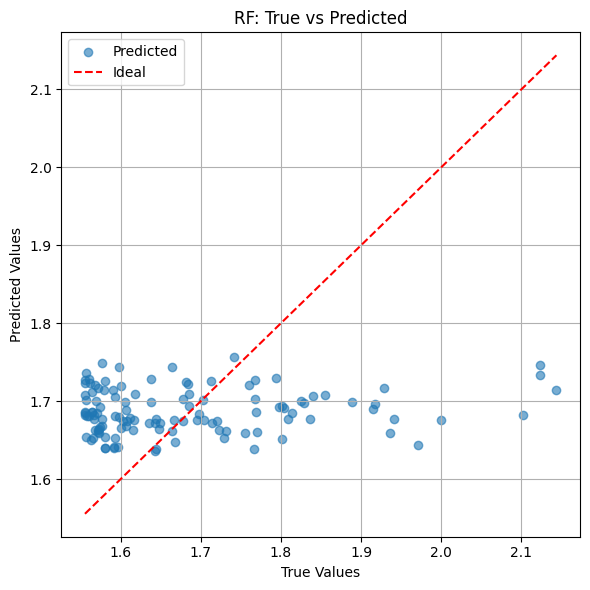

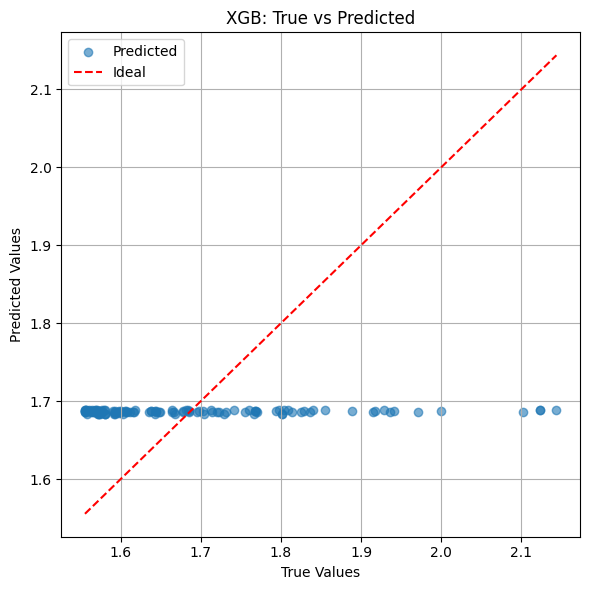

           RMSE        R2       MAE
model                              
RF     0.136398  0.010299  0.107811
XGB    0.136977  0.001871  0.108508
Dataset aggiornato salvato come: updated_dataset_20250511_153917.csv
  -> Active learning con Random Forest...
Dataset aggiornato salvato come: updated_dataset_20250511_153917.csv

>>> Iteration 2/5
  -> Tuning Random Forest...
Bayes RF best R²: 0.0665473719963171
  -> Tuning XGBoost...
Bayes XGB best R²: 0.11729599856472203
  -> Calcolo intervalli di confidenza...


c:\Users\aless\Desktop\Tesi\Articolo\.venv\lib\site-packages\forestci\calibration.py:100: UserWarning: Fitting the empirical bayes prior failed with message Desired error not necessarily achieved due to precision loss..
  warnings.warn("Fitting the empirical bayes prior failed with message %s." % res.message)


  -> Varianza stimata: 0.040024571223754885
XGBoost funziona correttamente!


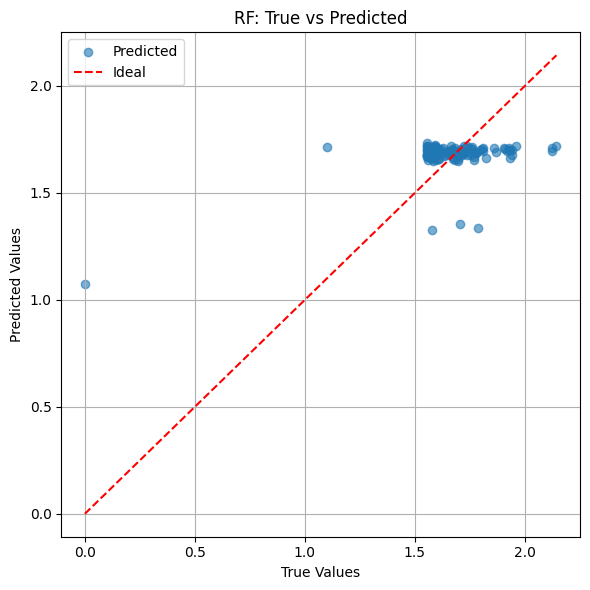

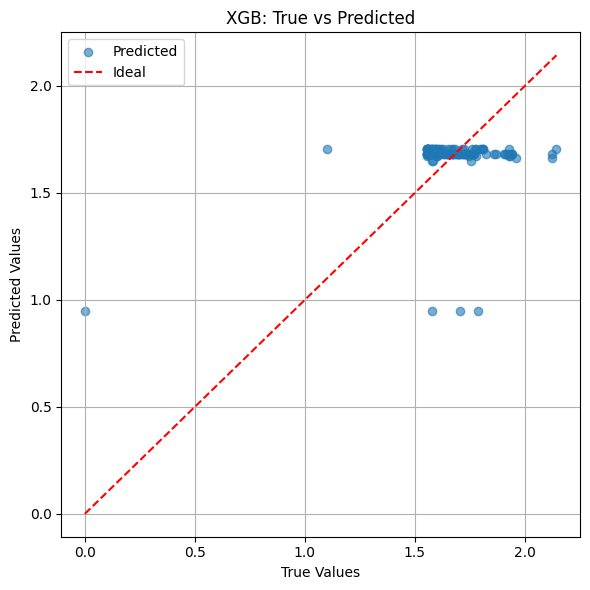

           RMSE        R2       MAE
model                              
RF     0.179675  0.239471  0.124982
XGB    0.203826  0.021281  0.135015
Dataset aggiornato salvato come: updated_dataset_20250511_154356.csv
  -> Active learning con Random Forest...
Dataset aggiornato salvato come: updated_dataset_20250511_154356.csv

>>> Iteration 3/5
  -> Tuning Random Forest...
Bayes RF best R²: -0.014512592334424345
  -> Tuning XGBoost...
Bayes XGB best R²: 0.031742743804830754
  -> Calcolo intervalli di confidenza...
  -> Varianza stimata: 0.028869592005219453
XGBoost funziona correttamente!


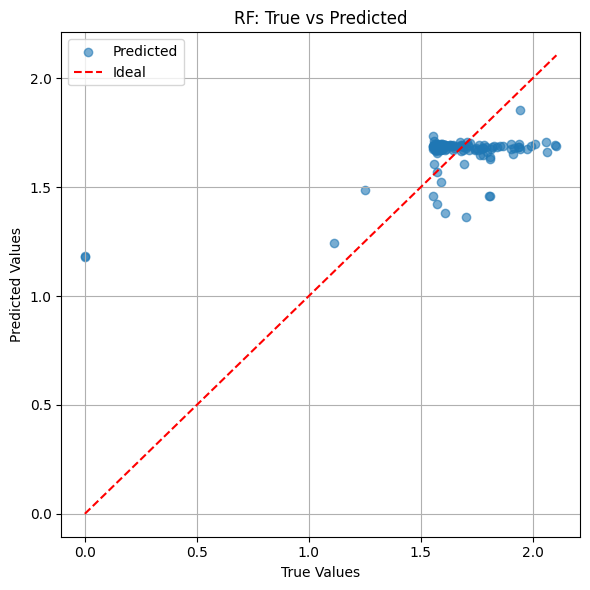

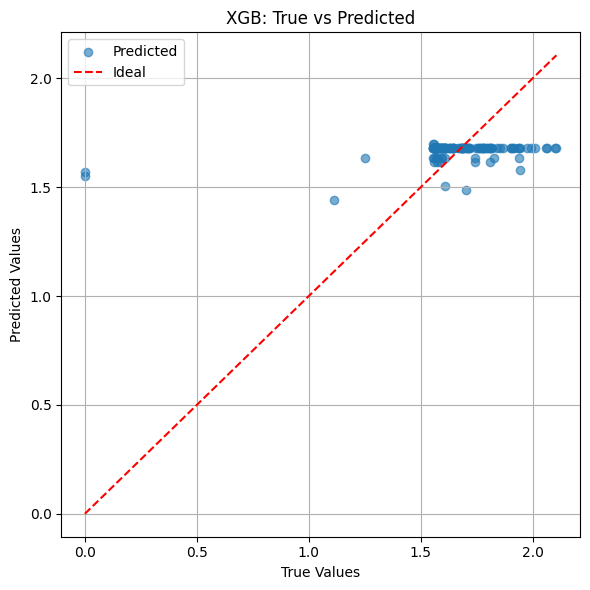

           RMSE        R2       MAE
model                              
RF     0.211980  0.332542  0.140772
XGB    0.246677  0.096165  0.141995
Dataset aggiornato salvato come: updated_dataset_20250511_154804.csv
  -> Active learning con Random Forest...
Dataset aggiornato salvato come: updated_dataset_20250511_154804.csv

>>> Iteration 4/5
  -> Tuning Random Forest...
Bayes RF best R²: 0.1500739736851393
  -> Tuning XGBoost...
Bayes XGB best R²: 0.09610797058213374
  -> Calcolo intervalli di confidenza...
  -> Varianza stimata: 0.031197717990237187
XGBoost funziona correttamente!


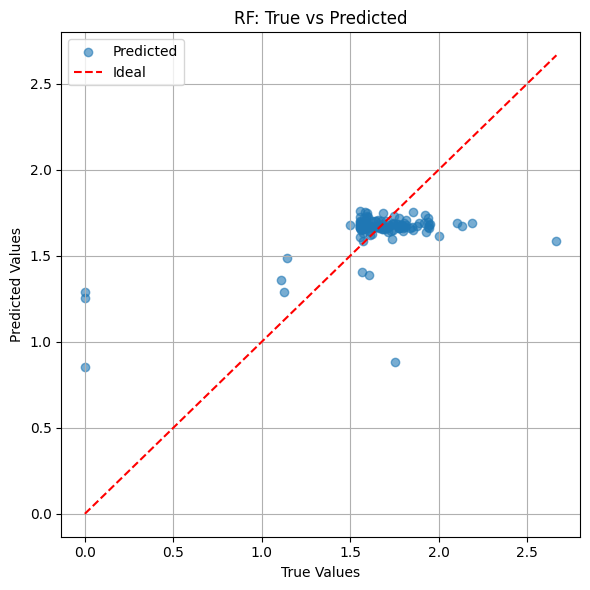

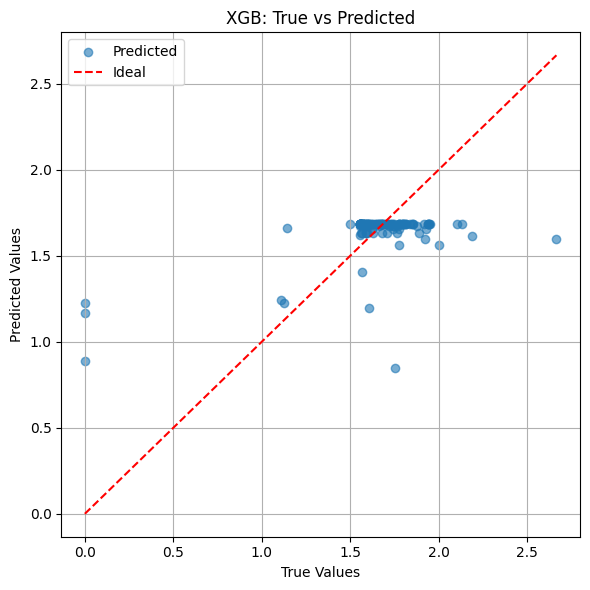

           RMSE        R2       MAE
model                              
RF     0.257019  0.316089  0.153779
XGB    0.258305  0.309230  0.155990
Dataset aggiornato salvato come: updated_dataset_20250511_155232.csv
  -> Active learning con Random Forest...
Dataset aggiornato salvato come: updated_dataset_20250511_155232.csv

>>> Iteration 5/5
  -> Tuning Random Forest...
Bayes RF best R²: 0.3404895074870389
  -> Tuning XGBoost...
Bayes XGB best R²: 0.3036645259905318
  -> Calcolo intervalli di confidenza...
  -> Varianza stimata: 0.2196046220380451
XGBoost funziona correttamente!


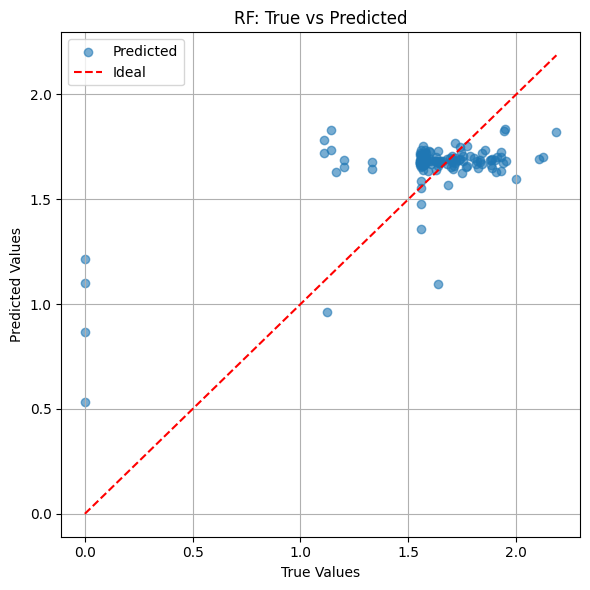

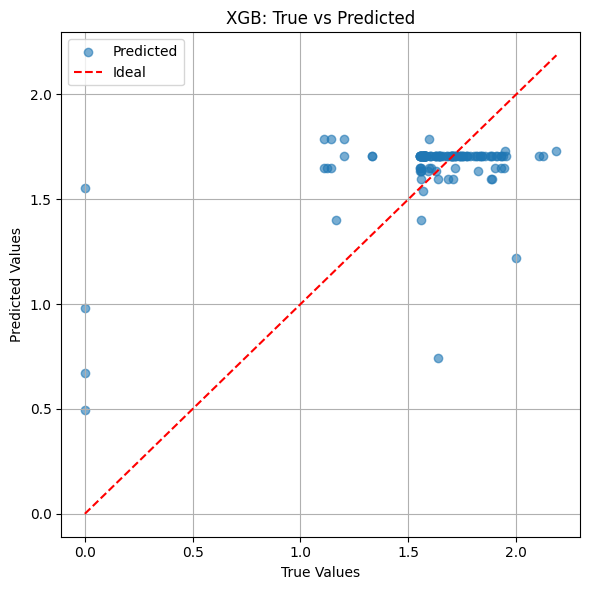

           RMSE        R2       MAE
model                              
RF     0.257892  0.421897  0.168670
XGB    0.279727  0.319862  0.179589
Dataset aggiornato salvato come: updated_dataset_20250511_155635.csv
  -> Active learning con Random Forest...
Dataset aggiornato salvato come: updated_dataset_20250511_155635.csv

>>> Pipeline completata.


In [2]:

def main_pipeline(
    dataset_path="dtlz2_surrogate_dataset_extended_updated.csv",
    n_iterations=5,
    top_k_ei=10,
    grid_step=0.05
):
    # Carica dati
    df, X, y = load_and_prepare(dataset_path)

    # Costruisci griglia di λ (∑=1)
    grid = np.arange(0,1+grid_step,grid_step)
    lambda_grid = np.array([lam for lam in product(grid, repeat=3) if np.isclose(sum(lam),1)])

    # Iterazioni di active learning
    for it in range(1, n_iterations+1):
        print(f"\n>>> Iteration {it}/{n_iterations}")

        # 1) Split stratificato su λ₁
        X_tr, X_te, y_tr, y_te = stratified_split(X, y, n_bins=10, test_size=0.2, random_state=42+it)

        # 2) Scale
        X_scaler = StandardScaler().fit(X_tr)
        y_scaler = StandardScaler().fit(y_tr)
        X_tr_s = X_scaler.transform(X_tr)
        X_te_s = X_scaler.transform(X_te)
        y_tr_s = y_scaler.transform(y_tr).ravel()
        y_te_s = y_scaler.transform(y_te).ravel()

        # 4) Tune Random Forest
        print("  -> Tuning Random Forest...")
        tuned_rf = tune_rf_bayes(X_tr_s, y_tr_s)

        print("  -> Tuning XGBoost...")
        tuned_xgb = tune_xgb_bayes(X_tr_s, y_tr_s)
        
        print("  -> Calcolo intervalli di confidenza...")
        variance = calculate_confidence_intervals(tuned_rf, X_tr_s, X_te_s)
        print(f"  -> Varianza stimata: {variance.mean()}")

        models = build_models(tuned_rf, tuned_xgb)
        print("XGBoost funziona correttamente!")
        perf = evaluate_models(models, X_tr_s, y_tr_s, X_te_s, y_te_s, y_scaler)
        print(perf)

        # Active learning con XGB
        lambda_selected = active_learning_with_xgb(
            lambda_candidates=lambda_grid,
            model=tuned_xgb,
            X_scaler=X_scaler,
            y_best_scaled=np.min(df["frob_norm"].values),
            top_k=top_k_ei
        )

        # Aggiorna il dataset
        df = update_dataset_with_new_data(lambda_selected, df)

        # 6) Active learning: aggiungi nuovi punti con EI
        #gp_model = models["GP"]
        #df = active_learning_with_ei(gp_model, X_scaler, y_scaler, lambda_grid, df, top_k=top_k_ei)

        print("  -> Active learning con Random Forest...")
        lambda_selected = diversity_enhanced_eiRF(lambda_candidates=lambda_grid, model=tuned_rf,X_scaler=X_scaler,y_best_scaled=np.min(df["frob_norm"].values), top_k=top_k_ei, w_ei=1.0,w_div=0.1,w_sigma=1.0)

        # Aggiorna il dataset con i nuovi punti selezionati
        df = update_dataset_with_new_data(lambda_selected, df)


        # 7) Ricostruisci X,y per la prossima it.
        X = df[["lambda_1","lambda_2","lambda_3"]].values
        y = df["frob_norm"].values.reshape(-1,1)

    print("\n>>> Pipeline completata.")
    
    
if __name__ == "__main__":
    main_pipeline(
        dataset_path="dtlz2_surrogate_dataset_extended_updated.csv",
        n_iterations=5,      # quante tornate di active learning
        top_k_ei=10,         # nuovi punti da EI per iterazione
        grid_step=0.05       # risoluzione griglia λ
    )